# Sentiment analysis Notebook
This notebook shows how the FinBERT pre-trained fine-tuned language model was used for financial sentiment analysis.

## Modules

In [2]:
%matplotlib inline

In [3]:
import sys
from pathlib import Path
import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from transformers import AutoModelForSequenceClassification

finbert_master_dir = Path.cwd() / 'finBERT-master'
sys.path.append(str(finbert_master_dir))
from finbert.finbert import *

project_dir = Path.cwd()

/Users/macbook/anaconda3/envs/finbert/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/Users/macbook/anaconda3/envs/finbert/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; 

## Load your fine-tuned FinBERT model

In [3]:
cl_path = project_dir/'finBERT-master'/'models'/'classifier_model'/'finbert-sentiment'
model = AutoModelForSequenceClassification.from_pretrained(cl_path, cache_dir=None, num_labels=3)

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/macbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load your dataset

### Dataset 
Due to limited computational recources we had to decrease the size of our dataset and randomly take 54 news headlines per day, rather than 107. The following sample shows the difference between the results of these two datasets for a period of 10 days. 

`Dataset_54`

   Date               Sentiment_score\
0  2007-01-01        -0.027784\
1  2007-01-02         0.023317\
2  2007-01-03        -0.020864\
3  2007-01-04        -0.080988\
4  2007-01-05        -0.125011\
5  2007-01-06        -0.105676\
6  2007-01-07        -0.015283\
7  2007-01-08        -0.013399\
8  2007-01-09        -0.011479\
9 2007-01-10        -0.043600

---

`Dataset_107`

   Date               Sentiment_score
0  2007-01-01        -0.009952\
1  2007-01-02        -0.000804\
2  2007-01-03        -0.029800\
3  2007-01-04        -0.087523\
4  2007-01-05        -0.106417\
5  2007-01-06        -0.066550\
6  2007-01-07         0.013264\
7  2007-01-08         0.011317\
8  2007-01-09        -0.045839\
9  2007-01-10         0.014067

In [1]:
data = {
    "Date": [
        "2007-01-01", "2007-01-02", "2007-01-03", "2007-01-04", "2007-01-05",
        "2007-01-06", "2007-01-07", "2007-01-08", "2007-01-09", "2007-01-10"
    ],
    "Sentiment_Score_54": [
        -0.027784, 0.023317, -0.020864, -0.080988, -0.125011,
        -0.105676, -0.015283, -0.013399, -0.011479, -0.043600
    ],
    "Sentiment_Score_107": [
        -0.009952, -0.000804, -0.029800, -0.087523, -0.106417,
        -0.066550, 0.013264, 0.011317, -0.045839, 0.014067
    ]
}

df = pd.DataFrame(data)

df['Difference'] = df['Sentiment_Score_54'] - df['Sentiment_Score_107']

# Calculate the variance of the differences
variance = df['Difference'].var()
variance


0.0008405051291111112

In [4]:
source_directory = '/Users/macbook/Desktop/Year3/Dissertation/Coding/Exp1/Results/Bloomberg & Reuters'
destination_directory = '/Users/macbook/Desktop/Year3/Dissertation/Coding/Exp2/Dataset_54'

In [26]:
# List all CSV files in the directory and sort them
csv_files = sorted([file for file in os.listdir(source_directory) if file.endswith('.csv')])

In [27]:
for file in csv_files:
    # Construct the full file path
    file_path = os.path.join(source_directory, file)

    df = pd.read_csv(file_path, usecols=['timestamp', 'headline'])

    # Randomly select 107 headlines
    selected_headlines = df.sample(n=54, random_state=1)
    
    selected_headlines['timestamp'] = pd.to_datetime(selected_headlines['timestamp']).dt.strftime('%Y-%m-%d %H:%M')
    selected_headlines.sort_values(by='timestamp', inplace=True)
    
    selected_headlines.reset_index(drop=True, inplace=True)

    base_name = os.path.splitext(file)[0]
    destination_file_name = f"{base_name}.csv" 

    destination_path = os.path.join(destination_directory, destination_file_name)
    selected_headlines.to_csv(destination_path, index=True)

## Sentiment analysis

In [5]:
def sentiment_analysis(file_path):
    df = pd.read_csv(file_path)
    sentiment_scores = [predict(headline, model) for headline in df['headline']]
    avg_sentiment = np.mean(sentiment_scores)
    return avg_sentiment

In [6]:
source_directory = '/Users/macbook/Desktop/Year3/Dissertation/Coding/Exp2/Dataset_54'

In [24]:
start_date = datetime(2007, 1, 1)
end_date = datetime(2016, 8, 16)

In [25]:
batch_size = 10
file_paths = [os.path.join(source_directory, current_date.strftime("%Y-%m-%d") + '.csv') for current_date in pd.date_range(start_date, end_date)]
num_batches = len(file_paths) // batch_size + (1 if len(file_paths) % batch_size else 0)

In [ ]:
results = []

for i in range(0, len(file_paths), batch_size):
    batch_paths = file_paths[i:i+batch_size]
    batch_results = []

    current_batch_number = (i // batch_size) + 1
    print(f"Processing batch {current_batch_number}/{num_batches}...") # Progress update
    
    # Process each file in the batch
    for file_path in batch_paths:
        if os.path.exists(file_path):
            avg_sentiment = sentiment_analysis(file_path)
            date_str = os.path.basename(file_path).replace('.csv', '')
            batch_results.append({'date': date_str, 'sentiment_score': avg_sentiment})
    
    # Extend the main results list with the batch results
    results.extend(batch_results)

In [27]:
final_df = pd.DataFrame(results)

In [29]:
final_df.sort_values(by='date', inplace=True)

In [ ]:
final_df.to_csv('/Users/macbook/Desktop/Year3/Dissertation/Coding/Exp2/Results/Sentiment_scores.csv', index=False)

### Plot the graph illustrating the performance based on sentiment scores by FinBERT

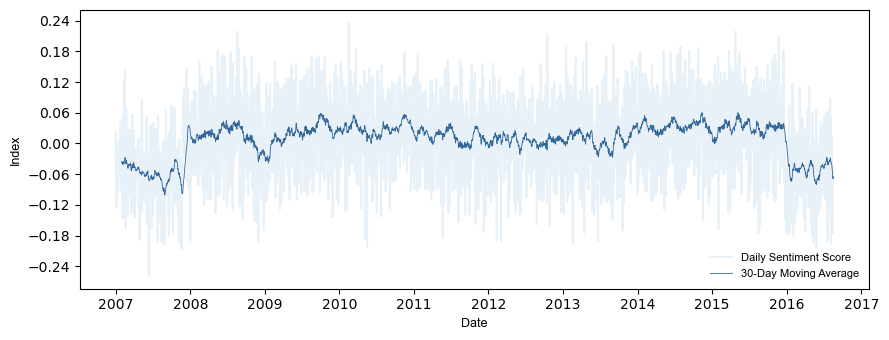

In [15]:
df = pd.read_csv('/Users/macbook/Desktop/Year3/Dissertation/Coding/Exp2/Results/Sentiment_scores.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df['Moving_Avg'] = df['sentiment_score'].rolling(window=30).mean()
plt.figure(figsize=(9, 3.5))
plt.plot(df.index, df['sentiment_score'], label='Daily Sentiment Score', alpha=0.1)
plt.plot(df.index, df['Moving_Avg'], label='30-Day Moving Average', color=(0.2, 0.4, 0.6), linewidth=0.6)
plt.xlabel('Date', fontsize=9, fontname='Arial')
plt.ylabel('Index', fontsize=9, fontname='Arial')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
legend = plt.legend(fontsize=8, frameon=False)
for text in legend.get_texts():
    text.set_fontname('Arial')
    text.set_fontsize(8)
plt.tight_layout()
plt.show()